<!-- # 全连接神经网络数据分析（最后转成英文） -->
# Fully Connected Neural Network Data Analysis

<!-- 在之前的章节中，我们介绍了神经网络的基本概念、以及如何对其进行编程。在这一章节中，我们以上市公司税收不遵从行为的分类为例，用```torch```展示神经网络的内部工作机制，并借此简单介绍```torch```的基本用法。 -->

In previous sections, we introduced the basic concepts of neural networks and how to programe them manually. Now in this section, we would demonstrate the usage of PyTorch as an example of **tax non-compliant company classification** .

**Learning Goal**：
* Preprocess your data;
* Using PyTorch to build, train and test network;
* Using sklearn to evalute model performance.

## Contents
* [1 - Import Packages](#1)
* [2 - Descriptive Analysis](#2)
* [3 - Model Analysis](#3) 
  * [3.1 - transform data structure](#3.1)
  * [3.2 - build network](#3.2)
  * [3.3 - define train and test functions](#3.3)
  * [3.4 - train and test network](#3.4)
* [4 - Model Evaluation and Comparison](#4)
  * [4.1 - probit & logit regression](#4.1)
  * [4.2 - draw precision-recall curve](#4.2)

<a name='1'></a>
## 1 - Import Packages

In [269]:
import pandas as pd # used for data import
import numpy as np # used for numerical operations
import torch # used for tensor operations
import torch.nn as nn # used for building neural networks
from torch.utils.data import DataLoader, TensorDataset # used for creating data loaders
from sklearn.preprocessing import StandardScaler # used for standardizing features
from sklearn.metrics import precision_recall_curve, average_precision_score # used for evaluating models
import statsmodels.api as sm # used for probit & logit regression
import matplotlib.pyplot as plt # used for plotting PR curves

np.random.seed(42) # set random seed for reproducibility
torch.manual_seed(42)

<a name='2'></a>
## 2 - Descriptive Analysis

The data we use includes financial reporting indicators and tax violation announcements for all listed companies in China from 2015-2024. The original data is highly imbalanced, so we use smote up-sampling algorithm to alliviate this problem.

In the following codes, we import the data file using `pandas`. And showing the first 5 observations to have a quick look at the dataset.

In [251]:
train_df = pd.read_csv('train_data.csv') # import training data
test_df = pd.read_csv('test_data.csv')
train_df.head(5) # display first 5 observations of training data

,noncompliance,股东权益/负债合计_EquTotLia,股东类别_SHType,每股收益(元/股)_BasicEPS,每股经营活动现金流量(元/股)_OpeCFPS,营业利润/营业总收入()_OpePrTOR,净利润()_NetPrf,有形净值债务率(%)_DbTanEquRt,每股现金及现金等价物余额(元/股)_CCEPS,资产负债率(%)_DbAstRt,...,每股资本公积金(元/股)_CapSurFdPS,股东权益周转率(次)_EquRat,产权比率(%)_DbEquRt,权益乘数(%)_EquMul,营业收入3年复合增长率(%)_OperaInc3GrRt,净资产收益率(扣除，加权)(%)_WROECut,流动资产/总资产(%)_CurTotAst,销售成本率(%)_SalCostRt,销售期间费用率(%)_PdCostRt,非流动资产/总资产(%)_NoncurTotAst
0,0.0,80.7537,0,0.0588,0.0753,3.9793,1.015744e+08,133.4197,0.3359,55.1437,...,0.9477,1.9469,122.9342,2.2293,90.2712,5.18,69.1845,88.9524,8.1304,30.8155
1,0.0,323.5963,0,0.7400,0.3335,13.3080,1.517207e+07,31.6858,0.9271,23.6074,...,0.3429,1.3302,30.9027,1.3090,52.6485,21.05,75.3315,39.3969,44.1717,24.6685
2,0.0,40.9974,0,-2.0400,1.0992,-21.5082,-9.471246e+08,364.3200,0.8515,71.0248,...,2.2845,1.9207,245.1222,3.4512,9.2016,-47.12,53.5268,79.3969,20.5129,46.4732
3,0.0,68.6448,0,1.2704,1.9955,12.4332,1.143370e+08,192.2331,0.6467,59.2962,...,1.9856,2.5506,145.6775,2.4568,8.3138,22.84,46.1873,73.8741,15.2662,53.8127
4,0.0,12.2972,1,-0.8900,-0.1791,-14.3990,-2.031099e+08,6375.7392,0.5305,86.7773,...,1.5777,4.1962,656.2752,7.5628,-3.9599,-60.48,72.8318,96.3563,12.5189,27.1682


In this dataset, `noncompliace` is the label of interest, `noncomplicance = 1` means this firm is announced to be tax non-compliant (like tax fraud or arrears) in either the current year or the next year. 

We firstly group the data by `noncompliance`, and report the sample size in each group. In training data after up-sampling, we have 1176 non-compliant observations and 23536 compliant observations.

We next calculate the sample mean in each group. It shows non-compliant firms and compliant firms may differ in terms of equity structure, solvency, and profitability.

In [252]:
# report sample size by group
train_df.groupby('noncompliance').size(), test_df.groupby('noncompliance').size()

(noncompliance
 0.0    23536
 1.0     1176
 dtype: int64,
 noncompliance
 0.0    10087
 1.0      483
 dtype: int64)

In [253]:
# report sample mean by group
train_df.groupby('noncompliance').mean().round(3).T

noncompliance,0.0,1.0
股东权益/负债合计_EquTotLia,2.489180e+02,1.538050e+02
股东类别_SHType,2.530000e-01,2.470000e-01
每股收益(元/股)_BasicEPS,5.000000e-01,3.320000e-01
每股经营活动现金流量(元/股)_OpeCFPS,6.320000e-01,4.630000e-01
营业利润/营业总收入()_OpePrTOR,-2.709000e+00,-2.411000e+00
净利润()_NetPrf,4.212471e+08,8.919762e+08
有形净值债务率(%)_DbTanEquRt,4.213800e+01,2.205610e+02
每股现金及现金等价物余额(元/股)_CCEPS,1.734000e+00,2.062000e+00
资产负债率(%)_DbAstRt,4.087700e+01,5.009700e+01
经营现金净流量(元)_NOCF,8.465880e+08,1.160996e+09


<a name='3'></a>
## 3 - Model Analysis

<a name='3.1'></a>
### 3.1 - transform data structure

In PyTorch, every network layers, loss functions and optimizer are designed to work with torch.Tensor objects. But we import train_data.csv as DataFrame. 

So in the following codes, we need to do transform:  DataFrame -> ndarray -> Tensor.

In [254]:
# transform DataFrame into numpy ndarray
X_train_array = train_df.drop(columns=['noncompliance']).values
y_train_array = train_df['noncompliance'].values
X_test_array = test_df.drop(columns=['noncompliance']).values
y_test_array = test_df['noncompliance'].values

# standardize input features
scaler = StandardScaler() # initialize the scaler
X_train_array = scaler.fit_transform(X_train_array)
X_test_array = scaler.transform(X_test_array) # standardize test data using the train scaler

# transform numpy ndarray into torch.tensor
X_train_tensor = torch.tensor(X_train_array, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_array, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_array, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_array, dtype=torch.float32)

After transform our data into Tensor, we further do transform: Tensor -> TensorDataset -> DataLoader.

`TensorDataset` and `DataLoader` are two useful tools in PyTorch. Our feature `X_train_tensor` and label `y_train_tensor` could be bundled into a `TensorDataset` objects. This allows the `DataLoader` to use it to easily loop batches, shuffle, and load them in parallel.

In [255]:
# bundle feature and label into TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# create DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True) # shuffle means randomize the order of observations
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

<a name='3.2'></a>
### 3.2 - build network

In the following codes, we build a neural network with 3 hidden layers (64, 32, 8 neurons respectively). We first define a class `FNN` inheriting from `nn.Module`.

In `__init__` method, `self.fc1 = nn.Linear(25, 64)` do the linear transformation of the 25 input features to 64 neurons, and vice versa. 

In `forward` method, `x = torch.relu(self.fc1(x))` do the nonlinear activation (ReLU) of the `self.fc1` output, and vice versa. After the sigmoid activation, `forward` method finally outputs the probability (remark: the output is probability or logits is important).

In [256]:
class FNN(nn.Module):
    """
    A fully connected neural network for binary classification.
    """
    def __init__(self):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(24, 64) # input layer: 25 features -> 64 neurons
        self.fc2 = nn.Linear(64, 32) # hidden layer1: 64 neurons -> 32 neurons
        self.fc3 = nn.Linear(32, 8) # hidden layer2: 32 neurons -> 8 neurons
        self.fc4 = nn.Linear(8, 1) # hidden layer3: 8 neurons -> output probability
        
    def forward(self, x):
        x = torch.relu(self.fc1(x)) # relu activation
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x)) # sigmoid activation
        return x

<a name='3.3'></a>
### 3.3 - define train and test functions

After defining our network, we would define a function `train` to do forward and backward propagation. In `train` function, we need to:
1. switch the model into train mode, since our model would behave differently in training (train mode) and testing (eval mode) like dropout et al;
2. forward propagation and return output;
3. calculate loss;
4. backpropagation;
5. update parameters.

Note that step 2 - 5 need to loop over the epochs and batches.

In [257]:
def train(model, train_loader, criterion, optimizer, num_epochs):
    """
    functions used to train the model
    params:
        model: the neural network to be trained;
        train_loader: a DataLoader object, trainging dataset;
        criterion: loss function;
        optimizer: optimiser that updates parameters after backpropagation;
        num_epochs: number of epochs in optimization;
    return:
        None
    """
    model.train() # set the model to training mode
    for epoch in range(num_epochs): # loop over epochs
        for batch_idx, (data, target) in enumerate(train_loader): # loop over batches
            optimizer.zero_grad() # clear previous gradients
            output = model(data) # do forward propagation
            loss = criterion(output.squeeze(1), target) # calculate loss
            loss.backward() # do backpropagation
            optimizer.step() # update parameters

            if (epoch + 1) % 50 == 0 and batch_idx == len(train_loader)-2: # print second last batch's loss every 50 epochs
                print(f"Epoch [{epoch+1}/{num_epochs}] Batch {batch_idx+1} Loss: {loss.item():.4f}")

We next define a `test` function to do test and return the predicted probabilities. In `test` function, we 
1. switch the model into eval mode.
2. do forward propagation using the test data and get output. Notice `model(data)` would return a tensor with shape [batch_size, 1], `.squeeze(1)` transform it into shape [batch_size];
3. calculate loss and return predicted probabilities.

In [258]:
def test(model, test_loader, criterion):
    """
    Run the trained model on the test set.
    params:
        model: the network after trained;
        test_loader: DataLoader, test dataset;
        criterion: loss function;
    return:
        pred_probs: tensor, predicted test probabilities;
    """
    model.eval() # set the model to evaluation mode
    test_loss = 0.0
    pred_probs = [] # a list used to accumulated each batch's predicted probabilities
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data).squeeze(1) # forward propagation using test data and return output probabilities
            test_loss += criterion(output, target).item() # accumulate loss
            pred_probs.append(output) # accumulate predicted probabilityes
            
    test_loss /= len(test_loader.dataset)
    print(f"Test Loss: {test_loss:.4f}")
    
    return torch.cat(pred_probs)

<a name='3.4'></a>
### 3.4 - train and test the network

So far, we have defined our network, training function and test function. Train and test is easy. We first instanciate a network `model = FNN()`, then set up the loss function and optimizer.

In [259]:
model = FNN() # instantiate the model
criterion = nn.BCELoss() # binary cross entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) # Adam optimizer

By calling the `train` function, we finish the training procedure. We find that the training loss flunctuates but generally decreases.

In [260]:
train(model, train_loader, criterion, optimizer, num_epochs=500)

Epoch [50/500] Batch 193 Loss: 0.1462
Epoch [100/500] Batch 193 Loss: 0.0701
Epoch [150/500] Batch 193 Loss: 0.1068
Epoch [200/500] Batch 193 Loss: 0.2252
Epoch [250/500] Batch 193 Loss: 0.0935
Epoch [300/500] Batch 193 Loss: 0.0724
Epoch [350/500] Batch 193 Loss: 0.1224
Epoch [400/500] Batch 193 Loss: 0.0777
Epoch [450/500] Batch 193 Loss: 0.1737
Epoch [500/500] Batch 193 Loss: 0.1121


We can get trained parameters by `model.named_parameters()`. Here, we show the dimension of each layers weights and bias.

In [261]:
for name, param in model.named_parameters():
    print(name, param.size())

fc1.weight torch.Size([64, 24])
fc1.bias torch.Size([64])
fc2.weight torch.Size([32, 64])
fc2.bias torch.Size([32])
fc3.weight torch.Size([8, 32])
fc3.bias torch.Size([8])
fc4.weight torch.Size([1, 8])
fc4.bias torch.Size([1])


By calling the `test` function, we finish the test procedure, and the predicted probabilities are assigned to `nn_pred_probs`.

In [262]:
nn_pred_probs = test(model, test_loader, criterion)
nn_pred_probs[:5] # present the first 5 predicted probabilities

Test Loss: 0.0018


tensor([0.0007, 0.0972, 0.1515, 0.0116, 0.1085])

<a name='4'></a>
## 4 - Models Evaluation and Comparison

So far we predicted the probabilities on test data using neural network. To evaluate our model performance, we compare our model with probit and logit regression in terms of precision, recall and the area under precision-recall curve.

<a name='4.1'></a>
### 4.1 - probit & logit regression

We first fit a probit and logit regression. 

In [263]:
train_with_const = sm.add_constant(X_train_array) # add a constant term to X_train
test_with_const = sm.add_constant(X_test_array)

# probit model
probit = sm.Probit(y_train_array, train_with_const).fit() # fit a probit model
probit_pred_probs = probit.predict(test_with_const) # predict probabilities on test data

probit_pred_probs[:5] # present the first 5 predicted probabilities

Optimization terminated successfully.
         Current function value: 0.180407
         Iterations 11


array([0.01006122, 0.050818  , 0.07519969, 0.06611171, 0.04115089])

In [264]:
# logit model
logit = sm.Logit(y_train_array, train_with_const).fit() # fit a probit model
logit_pred_probs = logit.predict(test_with_const) # predict probabilities on test data

logit_pred_probs[:5] # present the first 5 predicted probabilities

Optimization terminated successfully.
         Current function value: 0.180053
         Iterations 13


array([0.01098076, 0.04912958, 0.07527024, 0.06662138, 0.0410096 ])

<a name='4.2'></a>
### 4.2 - evaluate precision and recall

Our data is highly imbalanced, and the sample size of positive : negative = 483 : 10087. So, precision and recall is better for model performance. 

In the following codes, we calculate precision and recall for network, probit model, logit model and random guess. `sklearn` provides an easy implementations.

In [265]:
# precision and recall for neural network
precision_nn, recall_nn, _ = precision_recall_curve(y_test_array, nn_pred_probs)
auc_nn = average_precision_score(y_test_array, nn_pred_probs)

# probit
precision_probit, recall_probit, _ = precision_recall_curve(y_test_array, probit_pred_probs)
auc_probit = average_precision_score(y_test_array, probit_pred_probs)

# logit
precision_logit, recall_logit, _ = precision_recall_curve(y_test_array, logit_pred_probs)
auc_logit = average_precision_score(y_test_array, logit_pred_probs)

# random
rand_pred_probs = np.random.rand(len(y_test_array))
precision_rand, recall_rand, _ = precision_recall_curve(y_test_array, rand_pred_probs)
auc_rand = average_precision_score(y_test_array, rand_pred_probs)


Next, we draw precision-recall curve, and the area under the curve reflect the model's performance.

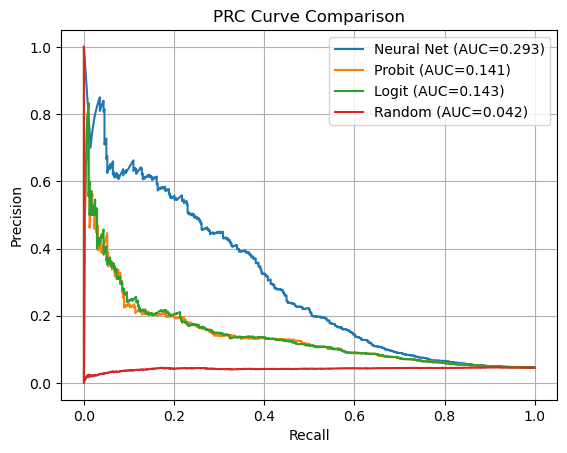

In [266]:
# draw PRC curves
plt.plot(recall_nn, precision_nn,  label=f"Neural Net (AUC={auc_nn:.3f})")
plt.plot(recall_probit, precision_probit,  label=f"Probit (AUC={auc_probit:.3f})")
plt.plot(recall_logit, precision_logit,  label=f"Logit (AUC={auc_logit:.3f})")
plt.plot(recall_rand, precision_rand,  label=f"Random (AUC={auc_rand:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PRC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()

Compared with probit and logit model, our neural network model has a better performance. But this neural network model can be further improved by tuning hyperparameters (network structure, loss functions, optimizer and learning rate et al.). We would talk about it in the next section.